In [1]:
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

In [2]:
# let's input data
train = pd.read_csv('Jerry_updated_datasets/train.csv')
test = pd.read_csv('Jerry_updated_datasets/test.csv')
validation = pd.read_csv('Jerry_updated_datasets/validation.csv')
# onehot encoding
train = pd.get_dummies(train, columns = ['label'], prefix ='', prefix_sep='', dtype=int)
test = pd.get_dummies(test, columns = ['label'], prefix ='', prefix_sep='', dtype=int)
validation = pd.get_dummies(validation, columns = ['label'], prefix ='', prefix_sep='', dtype=int)

In [3]:
# indices = np.arange(df_onehot.shape[0])

# np.random.seed(0)
# shuffled_indices = np.random.permutation(indices)

# df_onehot = df_onehot.reindex(shuffled_indices)

# # get split train and test set
# from sklearn.model_selection import train_test_split
# X = df_onehot.iloc[:,1:27]
# y = df_onehot.iloc[:,28].to_numpy()
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.25, random_state=100, shuffle=False)
X_train = train.iloc[:,1:27]
y_train = train.iloc[:,-2]
X_test = test.iloc[:,1:27]
y_test = test.iloc[:,-2]
X_validation = validation.iloc[:,1:27]
y_validation = validation.iloc[:,-2]

In [4]:
# EDA
#number of NAs
X_train.isna().sum()

chroma_stft           0
rmse                  0
spectral_centroid     0
spectral_bandwidth    0
rolloff               0
zero_crossing_rate    0
mfcc1                 0
mfcc2                 0
mfcc3                 0
mfcc4                 0
mfcc5                 0
mfcc6                 0
mfcc7                 0
mfcc8                 0
mfcc9                 0
mfcc10                0
mfcc11                0
mfcc12                0
mfcc13                0
mfcc14                0
mfcc15                0
mfcc16                0
mfcc17                0
mfcc18                0
mfcc19                0
mfcc20                0
dtype: int64

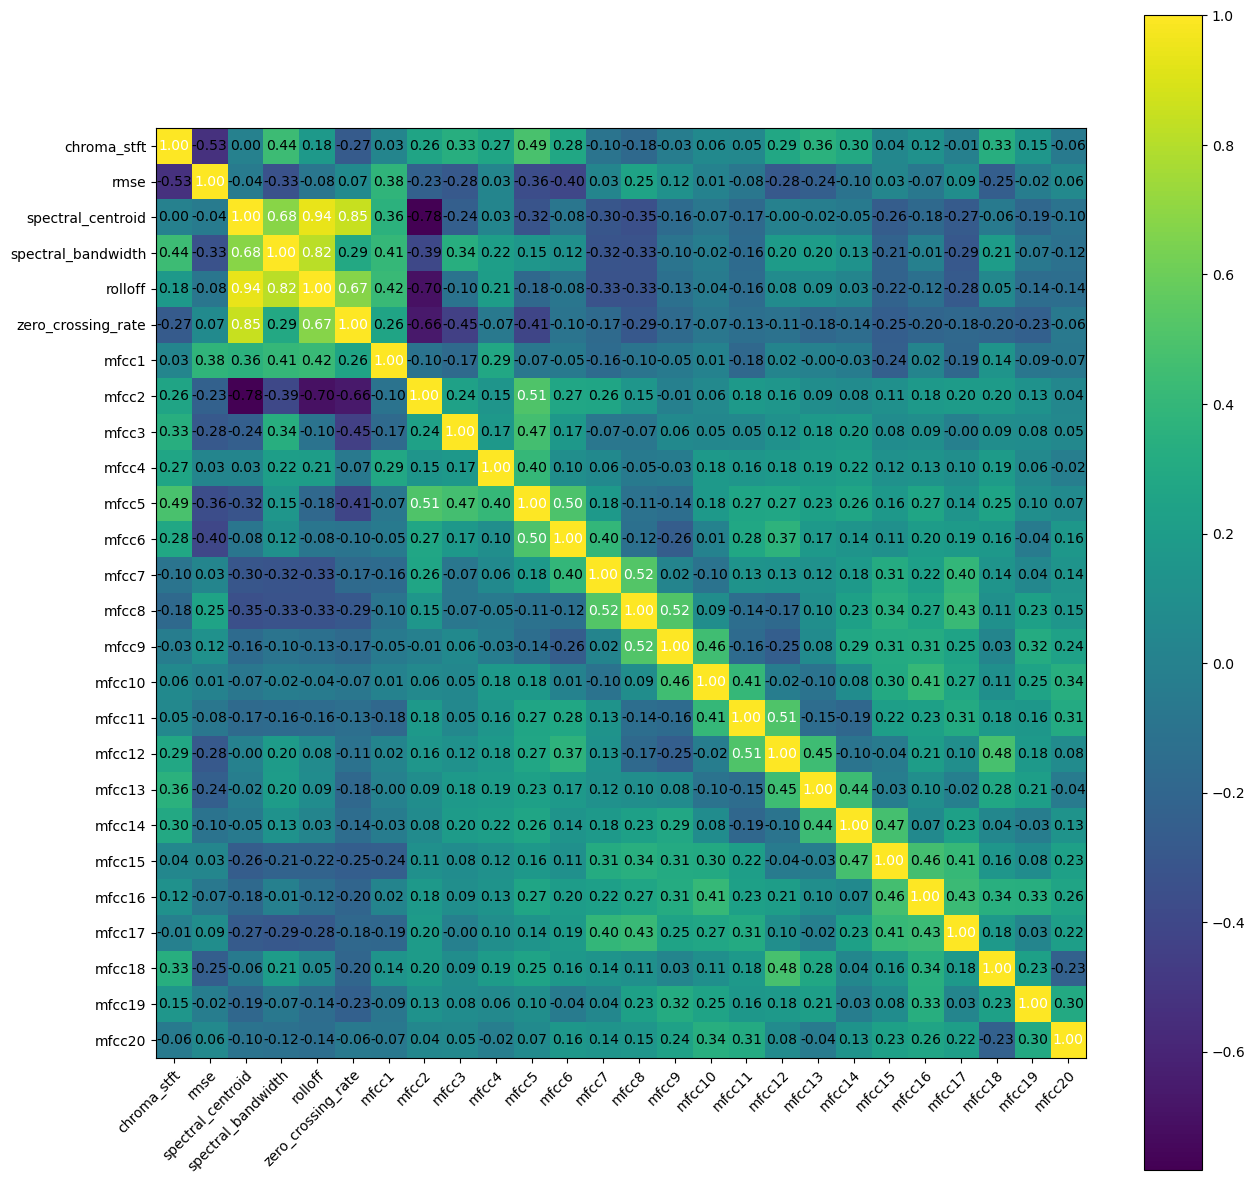

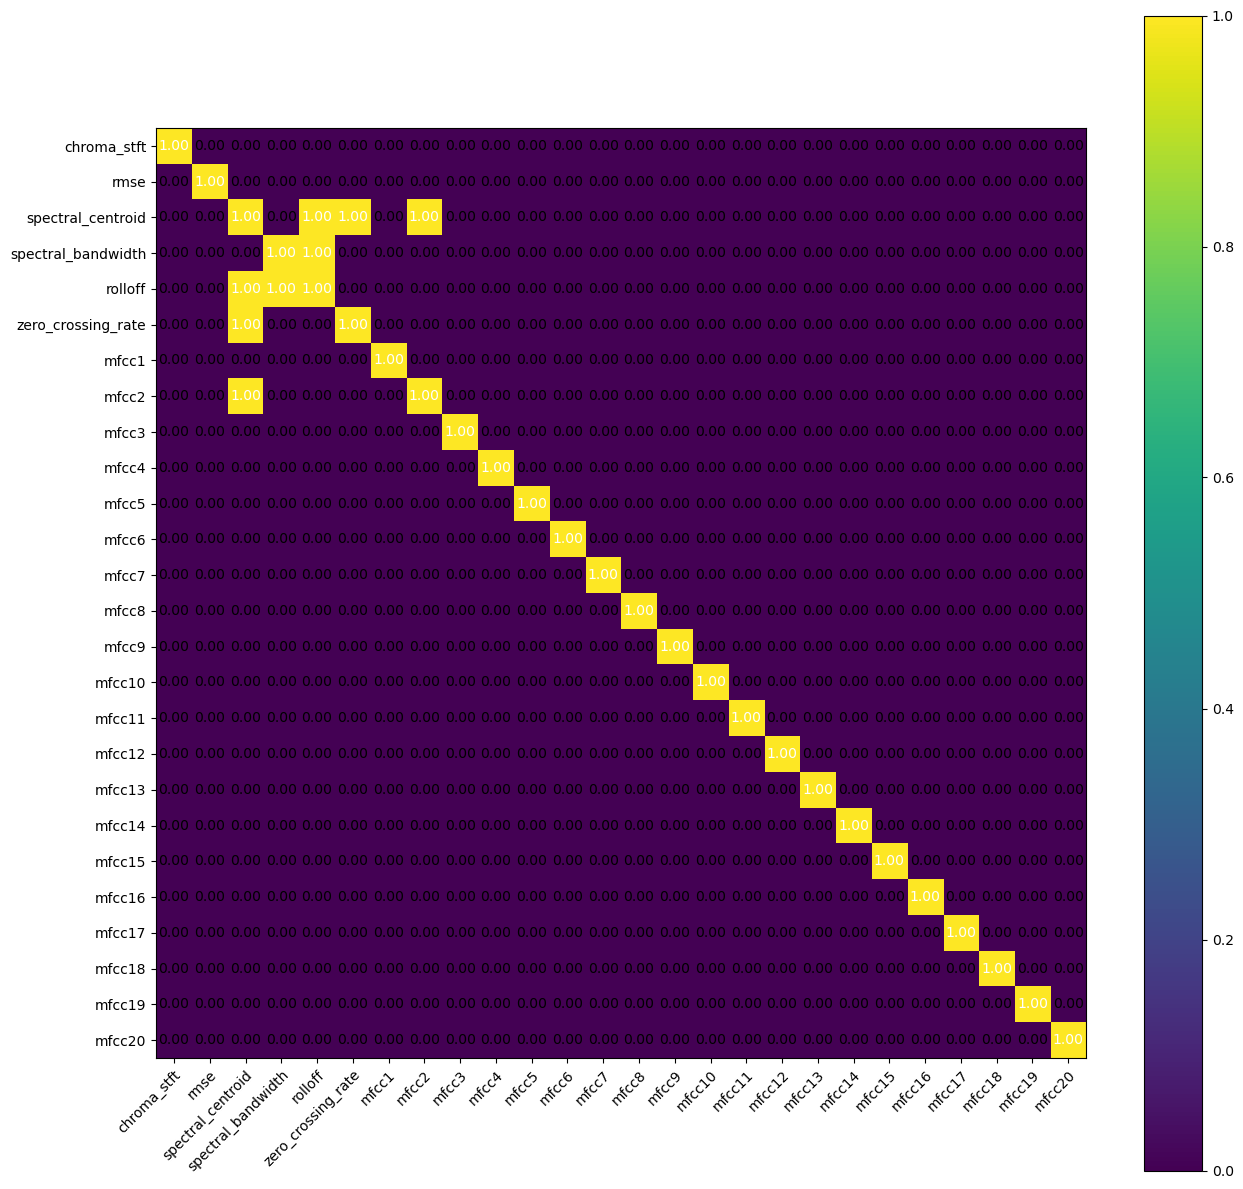

In [7]:
cm = X_train.corr().values
linear_dependent =  abs(cm) >0.7 
hm = heatmap(
    cm,
    row_names=X_train.columns,
    column_names=X_train.columns,
    figsize=(15, 15)
)

hm = heatmap(
    linear_dependent,
    row_names=X_train.columns,
    column_names=X_train.columns,
    figsize=(15, 15)
)

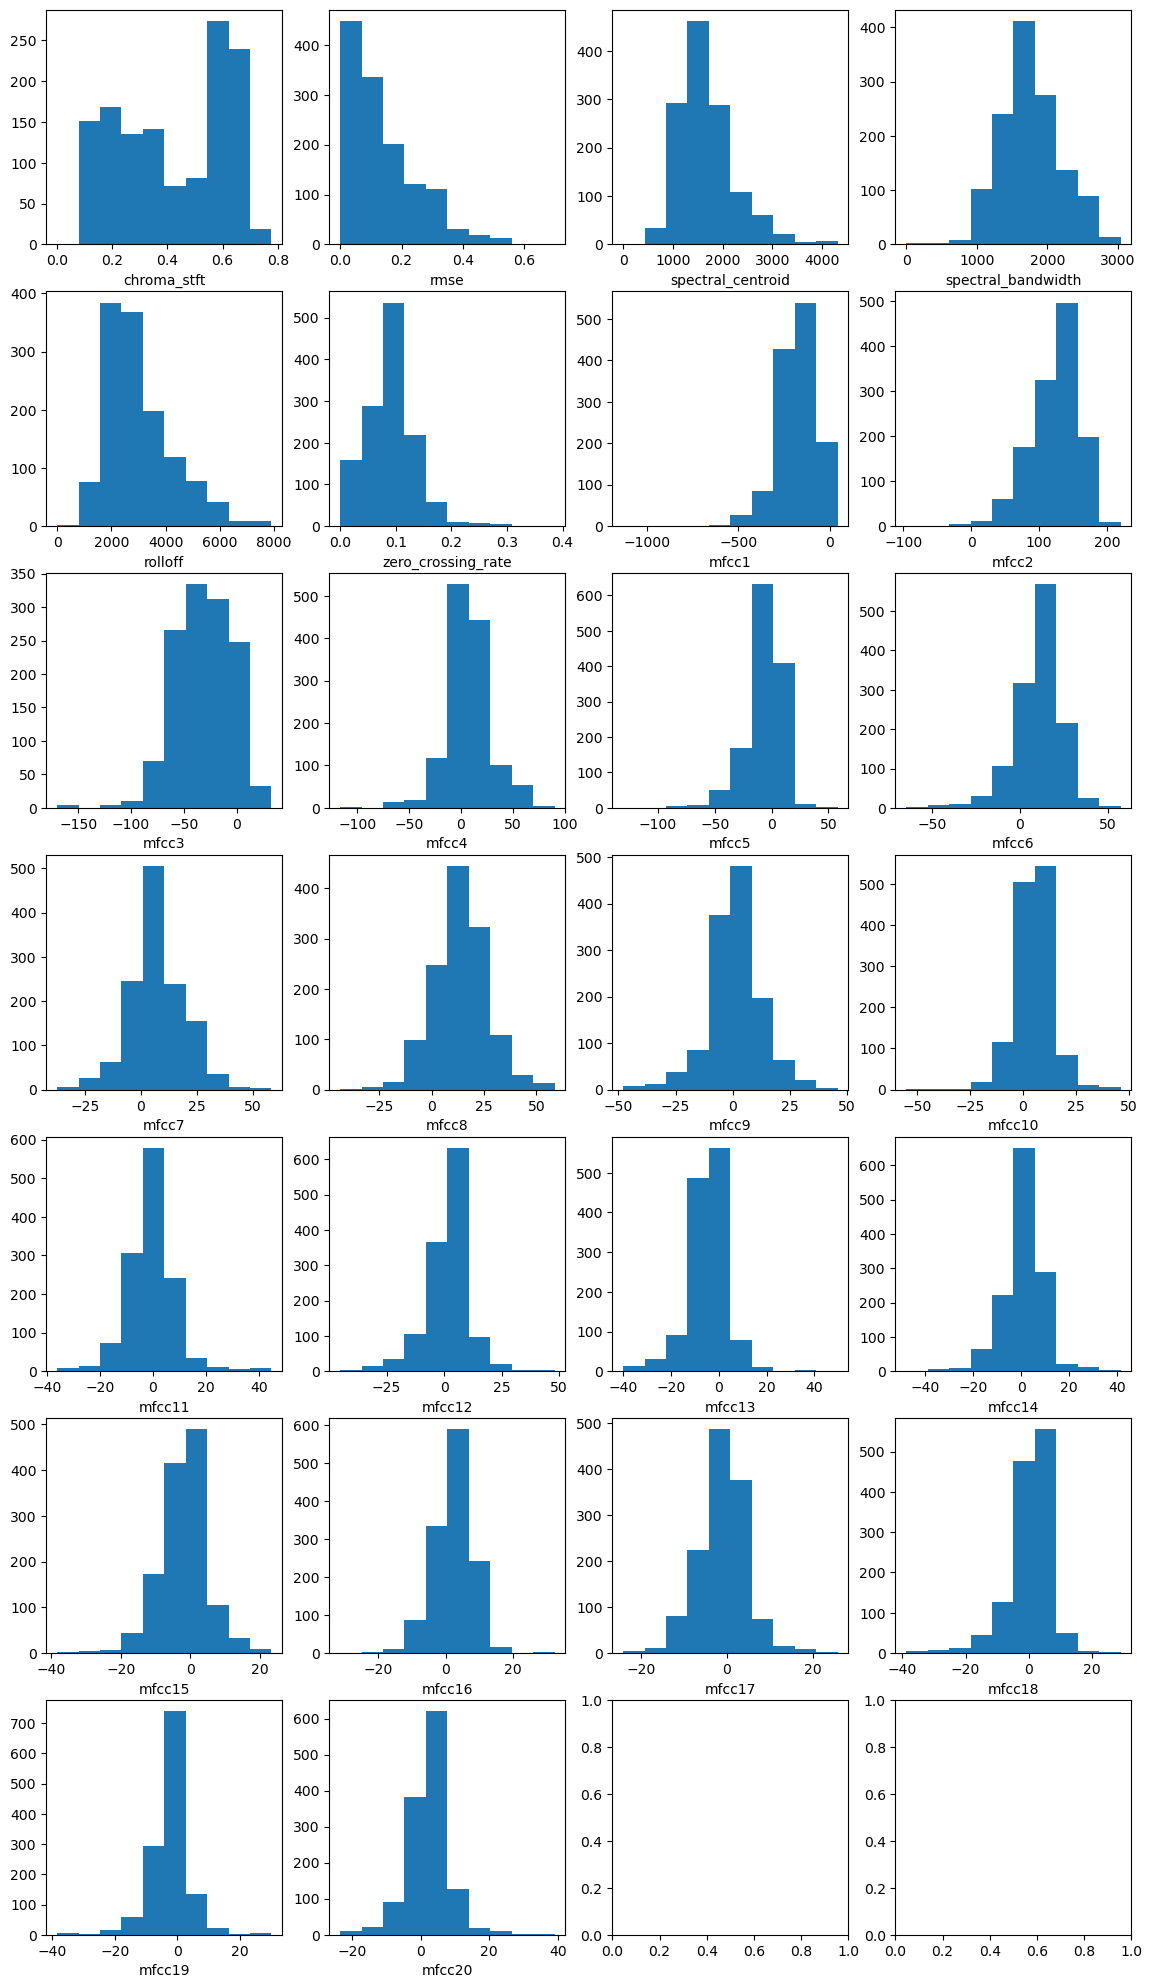

In [8]:
columns = X_train.columns
fig, axes = plt.subplots(nrows=7, ncols=4, figsize = (14,25))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(X_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])
    if idx == 25:
        break

There are many variables, we can consider reduce dimension later. For example: PCA or LDA

In [9]:
# standardization
sc_x = StandardScaler()
X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)
X_validation_std = sc_x.fit(X_train).transform(X_validation)

In [10]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    
    model.add(keras.layers.Dense(
        units=1,  
        use_bias=True,
        activation='sigmoid',
        # kernel_initializer='random_normal',
        # bias_initializer='zeros',
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))
  
  # Use Binary Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.02),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    return model



In [11]:
# Build a model
model = build_model(num_features=len(columns))
model.summary()

tf.random.set_seed(0)
np.random.seed(0)
# Train model
hist= model.fit(x=X_train_std,
                y=y_train,
                validation_data=(X_validation_std, y_validation),
                batch_size=400,
                epochs=50,
                verbose=1 
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 27        
                                                                 
Total params: 27 (108.00 Byte)
Trainable params: 27 (108.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


2023-07-19 23:47:25.704940: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-07-19 23:47:25.705024: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-19 23:47:25.705040: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-19 23:47:25.705210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-19 23:47:25.705247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-19 23:47:26.036691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 76ms/step - loss: 0.6764 - binary_accuracy: 0.6937 - val_loss: 0.6498 - val_binary_accuracy: 0.8473
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 0.6376 - binary_accuracy: 0.8924 - val_loss: 0.6169 - val_binary_accuracy: 0.8800
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 0.6045 - binary_accuracy: 0.9088 - val_loss: 0.5891 - val_binary_accuracy: 0.8909
Epoch 4/50
1/4 [======>.......................] - ETA: 0s - loss: 0.5860 - binary_accuracy: 0.9175

2023-07-19 23:47:26.405818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 12ms/step - loss: 0.5762 - binary_accuracy: 0.9135 - val_loss: 0.5646 - val_binary_accuracy: 0.8873
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 0.5510 - binary_accuracy: 0.9150 - val_loss: 0.5423 - val_binary_accuracy: 0.8873
Epoch 6/50
4/4 [==============================] - 0s 16ms/step - loss: 0.5284 - binary_accuracy: 0.9150 - val_loss: 0.5223 - val_binary_accuracy: 0.8836
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.5081 - binary_accuracy: 0.9205 - val_loss: 0.5046 - val_binary_accuracy: 0.8800
Epoch 8/50
4/4 [==============================] - 0s 12ms/step - loss: 0.4898 - binary_accuracy: 0.9213 - val_loss: 0.4884 - val_binary_accuracy: 0.8836
Epoch 9/50
4/4 [==============================] - 0s 12ms/step - loss: 0.4731 - binary_accuracy: 0.9205 - val_loss: 0.4742 - val_binary_accuracy: 0.8836
Epoch 10/50
4/4 [==============================] - 0s 13ms/step - loss: 0.4584 - binary_accur

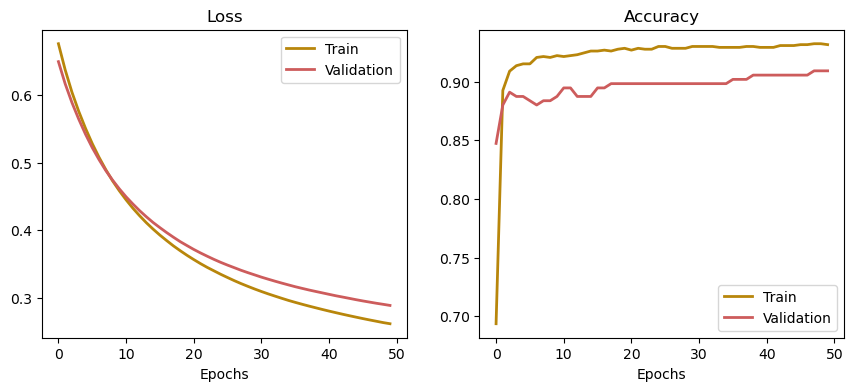

In [12]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');


In [13]:
y_train_pred_tf = model.predict(x=X_train_std).flatten()

# apply the threshold function to create a 0, 1 outcome
y_train_pred_tf = np.where(y_train_pred_tf>=0.5, 1, 0)

21/41 [==============>...............] - ETA: 0s

2023-07-19 23:47:30.644663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step


In [14]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std).flatten()
# apply the threshold function to create a 0, 1 outcome
y_test_pred_tf = np.where(y_test_pred_tf>=0.5, 1, 0)

9/9 [==============================] - 0s 3ms/step


Training, misclassified examples: 87
Training, prediction accuracy: 0.932
------------
Test, misclassified examples: 16
Test, prediction accuracy: 0.942


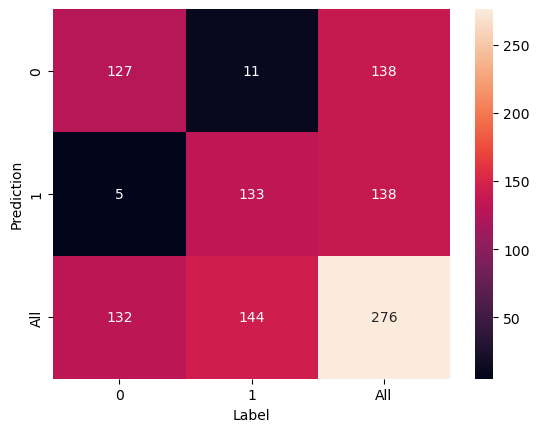

In [15]:
# print accuracy for train
print('Training, misclassified examples: %d' % (y_train != y_train_pred_tf).sum())
error_train_tf = (y_train != y_train_pred_tf).sum()/len(y_train_pred_tf)
print('Training, prediction accuracy: %.3f'% (1-error_train_tf))

# print accuracy for test
print('------------')
print('Test, misclassified examples: %d' % (y_test != y_test_pred_tf).sum())
error_test_tf = (y_test != y_test_pred_tf).sum()/len(y_test_pred_tf)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

confusion_matrix = pd.crosstab(y_test_pred_tf,y_test, rownames=['Prediction'], colnames=['Label'],margins = True)
sns.heatmap(confusion_matrix, annot=True,fmt='g')
pass

Training, misclassified examples: 65
Training, prediction accuracy: 0.949
------------
Validation, misclassified examples: 22
Validation, prediction accuracy: 0.920
------------
Test, misclassified examples: 13
Test, prediction accuracy: 0.953


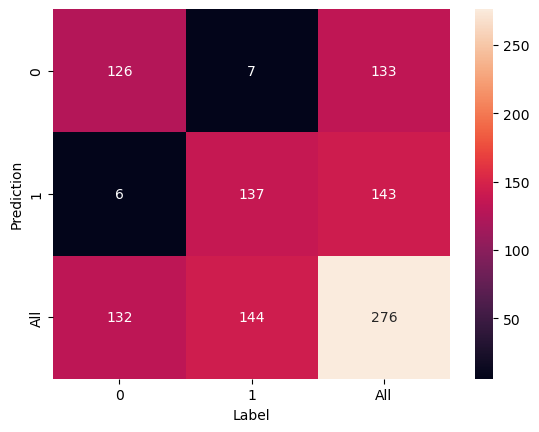

In [34]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train_std,y_train)

# print accuracy for train
lda_predict = clf.predict(X_train_std)
print('Training, misclassified examples: %d' % (y_train != lda_predict).sum())
error_train_tf = (y_train != lda_predict).sum()/len(lda_predict)
print('Training, prediction accuracy: %.3f'% (1-error_train_tf))

print('------------')
# print accuracy for validation
lda_predict = clf.predict(X_validation_std)
print('Validation, misclassified examples: %d' % (y_validation != lda_predict).sum())
error_train_tf = (y_validation != lda_predict).sum()/len(lda_predict)
print('Validation, prediction accuracy: %.3f'% (1-error_train_tf))


# print accuracy for test
print('------------')
lda_predict = clf.predict(X_test_std)
print('Test, misclassified examples: %d' % (y_test != lda_predict).sum())
error_test_tf = (y_test != lda_predict).sum()/len(lda_predict)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))
confusion_matrix = pd.crosstab(lda_predict,y_test, rownames=['Prediction'], colnames=['Label'],margins = True)
sns.heatmap(confusion_matrix, annot=True,fmt='g')
pass

Training, misclassified examples: 33
Training, prediction accuracy: 0.974
------------
Validation, misclassified examples: 11
Validation, prediction accuracy: 0.960
------------
Test, misclassified examples: 7
Test, prediction accuracy: 0.975


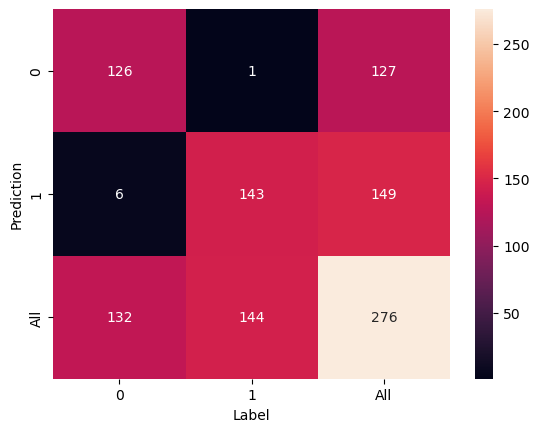

In [33]:
#SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_std,y_train)

# print accuracy for train
svm_predict = clf.predict(X_train_std)
print('Training, misclassified examples: %d' % (y_train != svm_predict).sum())
error_train_tf = (y_train != svm_predict).sum()/len(svm_predict)
print('Training, prediction accuracy: %.3f'% (1-error_train_tf))

print('------------')
# print accuracy for validation
svm_predict = clf.predict(X_validation_std)
print('Validation, misclassified examples: %d' % (y_validation != svm_predict).sum())
error_train_tf = (y_validation != svm_predict).sum()/len(svm_predict)
print('Validation, prediction accuracy: %.3f'% (1-error_train_tf))


# print accuracy for test
print('------------')
svm_predict = clf.predict(X_test_std)
print('Test, misclassified examples: %d' % (y_test != svm_predict).sum())
error_test_tf = (y_test != svm_predict).sum()/len(svm_predict)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))
confusion_matrix = pd.crosstab(svm_predict,y_test, rownames=['Prediction'], colnames=['Label'],margins = True)
sns.heatmap(confusion_matrix, annot=True,fmt='g')
pass

### t-sne

[Text(0.5, 1.0, 'Sound Feature t-SNE projection')]

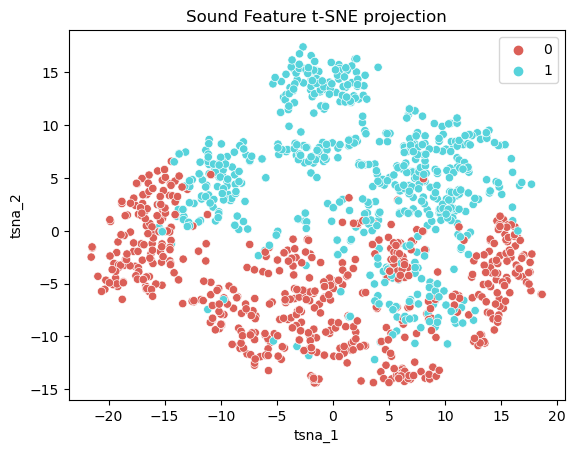

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=0)
z = tsne.fit_transform(X_train_std)
df = pd.DataFrame()
df["y"] = y_train
df["tsna_1"] = z[:,0]
df["tsna_2"] = z[:,1]

sns.scatterplot(x="tsna_1", y="tsna_2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Sound Feature t-SNE projection") 

### PCA

[Text(0.5, 1.0, 'Sound Feature PCA projection')]

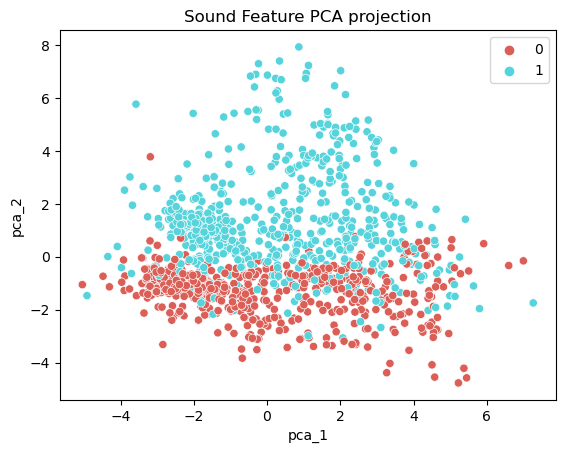

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, random_state=0)
z = pca.fit_transform(X_train_std)
df = pd.DataFrame()
df["y"] = y_train
df["pca_1"] = z[:,0]
df["pca_2"] = z[:,1]

sns.scatterplot(x="pca_1", y="pca_2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df).set(title="Sound Feature PCA projection") 

### LDA

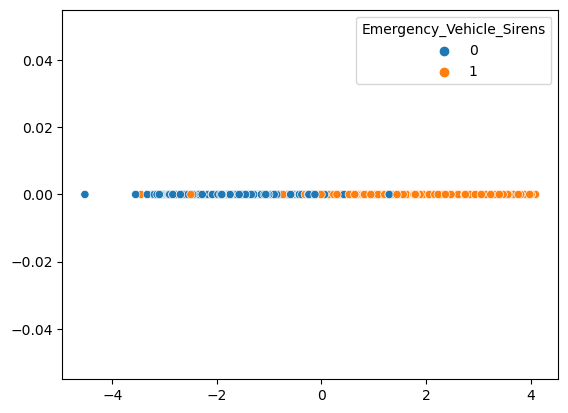

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
z = lda.fit_transform(X_train_std, y_train)

x = z[:,0]
y = np.zeros(x.shape)
sns.scatterplot(x=x,y=y, hue = y_train)
plt.show()

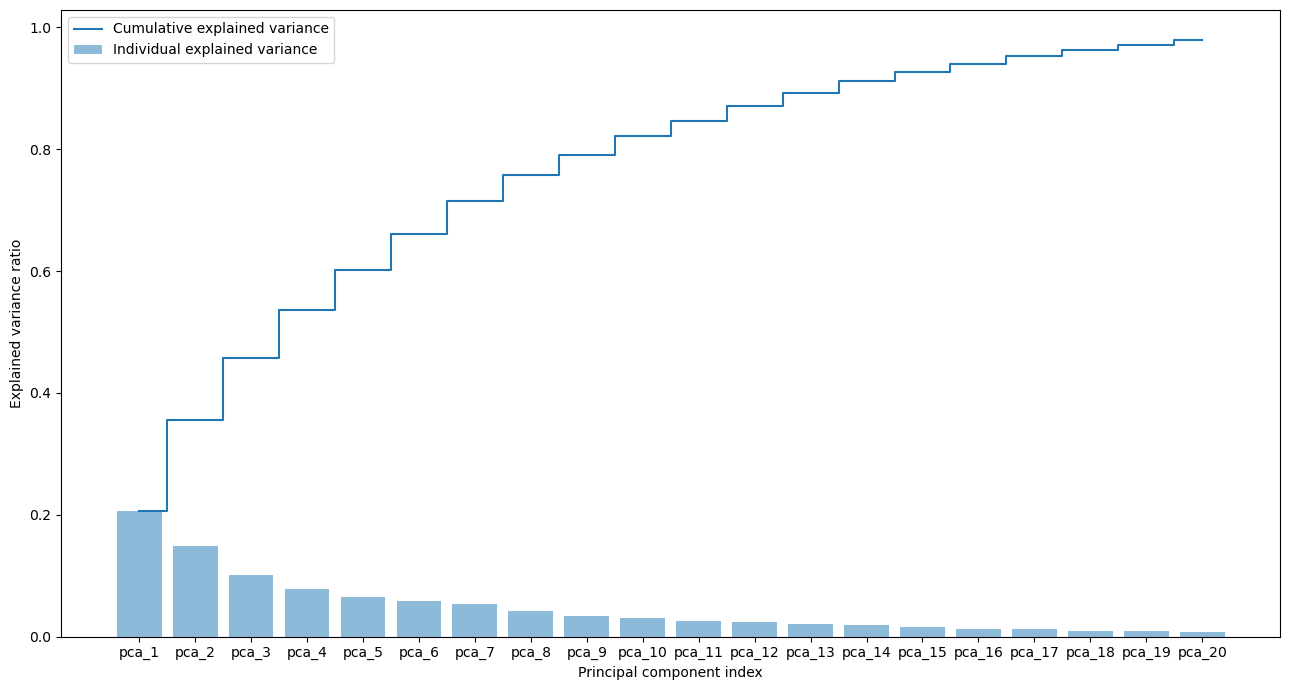

In [21]:
x_label = ['pca_' + str(i) for i in range(1,21)]
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
fig, ax = plt.subplots(figsize=(13,7))
plt.bar(x_label, exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### Explained variance suggest up to 17 components to reach 90%. Let's fit the PCA with n=17 and examine the loadings. 

In [22]:
pca = PCA(n_components=17)
pca.fit_transform(X_train_std)

array([[-1.0258692 , -0.69853261,  0.99290458, ..., -0.71535183,
        -0.33353423, -0.86802274],
       [ 4.61401755,  1.79175962,  2.03970525, ...,  0.49901177,
         1.00272879,  0.42470049],
       [-2.3742639 ,  1.23239954, -1.54299859, ..., -1.19747557,
         1.36296772,  0.38640025],
       ...,
       [ 4.6520233 , -2.29584895,  0.52825218, ..., -0.5773296 ,
        -0.31499896,  0.5090141 ],
       [ 3.5020972 ,  0.52986841,  3.15990119, ..., -0.0401268 ,
         0.51348522, -0.120496  ],
       [-2.35754029,  1.21225693, -1.11425961, ...,  0.25269407,
         0.60257952, -0.09232166]])

In [23]:
components = pd.DataFrame(pca.components_, columns=X_train.columns)
#First principal component
components[components.loc[0, :].abs().sort_values(ascending=False).index].loc[0, :]

spectral_centroid     0.352249
zero_crossing_rate    0.328505
mfcc2                -0.314408
rolloff               0.313330
mfcc5                -0.235733
mfcc17               -0.234651
mfcc15               -0.228395
mfcc16               -0.221187
mfcc7                -0.214755
mfcc8                -0.194577
spectral_bandwidth    0.191847
mfcc11               -0.163868
mfcc1                 0.159518
mfcc19               -0.151334
mfcc6                -0.151021
mfcc3                -0.140941
mfcc10               -0.135631
mfcc18               -0.129919
mfcc20               -0.129259
mfcc14               -0.125150
mfcc9                -0.123267
mfcc12               -0.102886
chroma_stft          -0.099611
mfcc13               -0.089361
rmse                  0.070791
mfcc4                -0.065235
Name: 0, dtype: float64

In [24]:
# Second principal component
components[components.loc[1, :].abs().sort_values(ascending=False).index].loc[1, :]

spectral_bandwidth   -0.381103
chroma_stft          -0.365220
rmse                  0.300563
mfcc12               -0.291728
mfcc5                -0.283849
rolloff              -0.252622
mfcc13               -0.239077
mfcc6                -0.234903
mfcc18               -0.234169
mfcc4                -0.217638
mfcc8                 0.216891
mfcc3                -0.207334
spectral_centroid    -0.168665
mfcc9                 0.137005
mfcc14               -0.105817
mfcc1                -0.105172
mfcc11               -0.082061
mfcc17                0.070178
mfcc16               -0.069391
mfcc7                 0.067023
mfcc20                0.052430
mfcc15                0.047805
mfcc19               -0.029219
mfcc2                -0.019479
mfcc10               -0.012498
zero_crossing_rate   -0.010482
Name: 1, dtype: float64

* Component 1 has relatively high loadings on variables such as spectral_bandwidth, zero_crossing_rate, and mfcc1. This suggests that Component 1 is capturing information related to spectral characteristics, such as the width of the frequency bands, the rate of signal crossings through zero, and the first Mel-frequency cepstral coefficient (remember that MFCC 1 indicates the loudness of a signal).

* Component 2 has high loadings on variables such as chroma_stft, spectral_centroid, and rolloff. This indicates that Component 2 is capturing information related to chroma features (related to musical pitch), spectral centroid (indicating the average frequency content), and rolloff (the frequency below which a certain percentage of the total energy falls).

In [25]:
pd.options.display.max_columns = 50
components

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,-0.099611,0.070791,0.352249,0.191847,0.313330,0.328505,0.159518,-0.314408,-0.140941,-0.065235,-0.235733,-0.151021,-0.214755,-0.194577,-0.123267,-0.135631,-0.163868,-0.102886,-0.089361,-0.125150,-0.228395,-0.221187,-0.234651,-0.129919,-0.151334,-0.129259
1,-0.365220,0.300563,-0.168665,-0.381103,-0.252622,-0.010482,-0.105172,-0.019479,-0.207334,-0.217638,-0.283849,-0.234903,0.067023,0.216891,0.137005,-0.012498,-0.082061,-0.291728,-0.239077,-0.105817,0.047805,-0.069391,0.070178,-0.234169,-0.029219,0.052430
2,0.024271,-0.158827,-0.236625,-0.150243,-0.253154,-0.181734,-0.168923,0.261526,0.094872,-0.135116,0.103591,0.096272,-0.040100,-0.243316,-0.377501,-0.326907,-0.007562,0.052712,-0.048270,-0.217868,-0.269798,-0.299520,-0.218522,-0.086606,-0.166438,-0.214580
3,-0.174127,0.033878,0.089235,-0.114658,0.014008,0.197743,-0.005907,-0.049792,-0.218772,-0.011773,-0.006877,0.204952,0.071835,-0.196648,-0.254187,0.183752,0.534375,0.294845,-0.268873,-0.377498,-0.011027,0.144013,0.147608,0.040834,0.016703,0.203638
4,0.104862,-0.055663,-0.091269,0.071019,-0.048451,-0.164549,-0.063227,0.041908,0.263420,-0.028541,0.045834,-0.268470,-0.518137,-0.228752,0.214009,0.378969,0.121642,-0.127022,-0.197173,-0.188859,-0.094238,0.035110,-0.215609,-0.134358,0.267556,0.176200
5,0.030668,-0.280823,0.108214,0.040365,0.039250,0.140387,-0.402880,-0.141285,0.155004,-0.158358,0.105763,0.247496,0.041716,-0.141047,-0.021714,0.062302,0.038608,-0.239408,-0.156620,0.296251,0.253800,-0.092012,0.097380,-0.399952,-0.290685,0.240581
6,0.030886,-0.352284,0.075991,-0.010415,0.003998,0.054355,-0.416918,-0.175992,-0.080319,-0.489484,-0.266959,-0.025985,0.024827,0.114599,0.142075,-0.111219,-0.031624,0.234040,0.268238,-0.116167,-0.080731,0.053172,-0.061724,0.150200,0.343268,0.047262
7,-0.081976,0.205957,-0.013273,-0.025832,-0.024513,0.006179,0.161716,0.005515,0.026269,0.095503,0.041460,0.151387,0.128805,0.015819,-0.045522,-0.123859,-0.006557,0.140576,0.319685,0.121551,-0.243106,-0.175671,-0.206526,-0.407512,0.296448,0.575461
8,-0.036656,0.159683,-0.030095,-0.194169,0.018310,-0.038092,-0.309039,-0.166000,-0.037799,0.297709,-0.107234,-0.372603,-0.198709,-0.147199,-0.095122,0.008802,0.311441,0.265748,0.316175,0.266851,0.215011,-0.300347,0.066688,-0.006473,-0.056756,-0.126845
9,-0.258342,0.244878,0.004515,0.262844,0.066447,-0.183909,-0.077316,-0.271870,0.681456,-0.055070,-0.036184,-0.077148,0.113028,0.157819,-0.074310,-0.267185,0.082782,0.143704,-0.115809,-0.184435,0.065863,0.076797,0.093806,0.020323,-0.046153,0.016740


The need for a larger number of components to explain a significant portion of the variance indicates that the Spectral and MFCC features contain a rich set of information, and each component contributes to capturing specific aspects of the variability present in the data. (<b>Big thanks for the analysis, Frances!</b>)

### Try a simple FNN model

In [26]:
def build_model(num_features,
                n_classes,
                hidden_layer_sizes=[],
                drop_rate = 0.3,
                learning_rate=0.01):
    
    
    """Build a FNN based on hw6, live section 3
    """
    
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = tf.keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),name='Input'))


    # add hidden layers
    count_hidden = 1
    for i in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=i,
                                        use_bias=True,
                                        activation='relu',
                                        name='hidden_layer_' + str(count_hidden)
                                       ))
        model.add(tf.keras.layers.Dropout(rate=drop_rate, name='Dropout' + str(count_hidden)))
        count_hidden +=1
    
    # create output layer
    model.add(keras.layers.Dense(
      units=n_classes,
      use_bias=True,
      activation=None,
      name='Output'
    ))
    
    
    
    # set a optimizer dictionary
    options = {'SGD': tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate), 
               'Adam': tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)}
    
    # Create optimizer
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    return model

In [27]:
# build model
model = build_model(num_features = X_train_std.shape[1],
                    n_classes = 1,
                    hidden_layer_sizes=[15, 4],
                    drop_rate = 0.1,
                    learning_rate=0.02)

# train model
num_epochs = 1500
batch_size=400
# es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)
hist = model.fit(
                x=X_train_std,
                y=y_train,
                epochs=num_epochs,
                batch_size=batch_size,
                validation_data = (X_validation_std, y_validation),
                # callbacks=[es],
                verbose=0)

2023-07-19 23:47:45.934070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-19 23:47:46.370419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


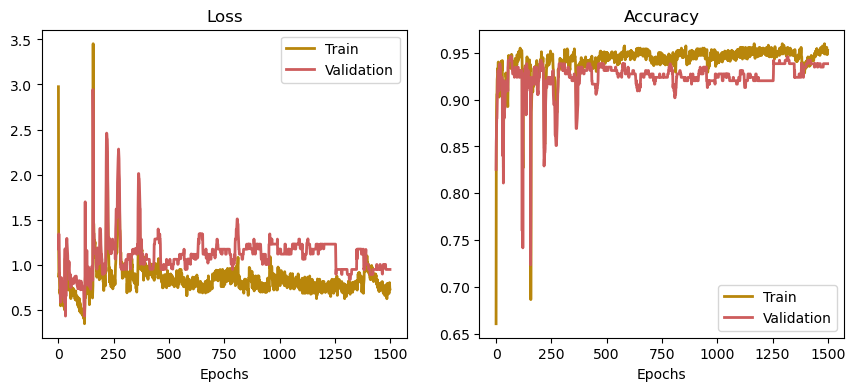

In [28]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');


9/9 [==============================] - 0s 2ms/step
Training, misclassified examples: 58
Training, prediction accuracy: 0.955
------------
Training, misclassified examples: 17
Training, prediction accuracy: 0.938
------------
Test, misclassified examples: 12
Test, prediction accuracy: 0.957


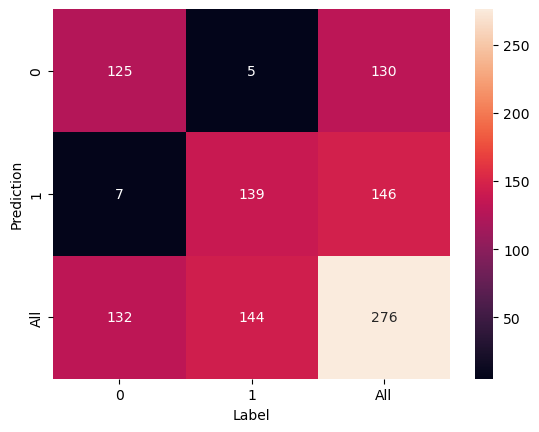

In [37]:
y_train_pred_tf = model.predict(x=X_train_std).flatten()

# apply the threshold function to create a 0, 1 outcome
y_train_pred_tf = np.where(y_train_pred_tf>=0.5, 1, 0)


y_validation_pred_tf = model.predict(x=X_validation_std).flatten()
y_validation_pred_tf = np.where(y_validation_pred_tf>=0.5, 1, 0)


# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std).flatten()
# apply the threshold function to create a 0, 1 outcome
y_test_pred_tf = np.where(y_test_pred_tf>=0.5, 1, 0)


# print accuracy for train
print('Training, misclassified examples: %d' % (y_train != y_train_pred_tf).sum())
error_train_tf = (y_train != y_train_pred_tf).sum()/len(y_train_pred_tf)
print('Training, prediction accuracy: %.3f'% (1-error_train_tf))

print('------------')
print('Training, misclassified examples: %d' % (y_validation != y_validation_pred_tf).sum())
error_train_tf = (y_validation != y_validation_pred_tf).sum()/len(y_validation_pred_tf)
print('Training, prediction accuracy: %.3f'% (1-error_train_tf))

print('------------')

# print accuracy for test

print('Test, misclassified examples: %d' % (y_test != y_test_pred_tf).sum())
error_test_tf = (y_test != y_test_pred_tf).sum()/len(y_test_pred_tf)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

confusion_matrix = pd.crosstab(y_test_pred_tf,y_test, rownames=['Prediction'], colnames=['Label'],margins = True)
sns.heatmap(confusion_matrix, annot=True,fmt='g')
pass

## get misclassified data

In [28]:
train_size = len(y_train)
misclassified_indices = np.where(y_test != y_test_pred_tf)[0]
misclassified_indices = misclassified_indices + train_size

In [29]:
df_onehot.iloc[misclassified_indices]

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,Emergency_Vehicle_Sirens,Road_Noises
1522,ambulance658.wav,0.573286,0.078372,1357.556115,2084.779567,2971.582031,0.040255,-187.421127,131.280884,9.199614,21.709503,4.566490,22.409893,9.038013,14.070734,2.993679,8.011272,1.830046,7.354259,5.675764,2.420849,-4.923316,3.495291,-1.636103,4.080669,0.974962,-0.724802,Emergency_Vehicle_Sirens,1,0
449,road503.wav,0.314996,0.083367,1948.278664,2206.945478,3797.049091,0.085400,-128.576126,111.477386,-26.034742,-12.658325,-6.958997,5.020277,-5.617709,11.434407,-11.744179,4.691355,2.435247,-0.620151,-2.579094,-15.936925,-17.888359,-3.880656,-7.474600,9.139002,-0.334498,-3.665566,Road_Noises,0,1
890,road900.wav,0.656491,0.030865,1315.829140,1165.209051,2737.297451,0.089318,-307.032715,177.606720,-71.701889,40.453712,54.875896,-28.823046,20.887312,27.155670,-14.378946,13.115305,9.907723,-9.734148,9.052631,2.004428,-2.711749,10.691092,-1.182455,1.007617,10.080186,-4.924923,Road_Noises,0,1
1338,ambulance492.wav,0.329132,0.200761,2829.753710,2374.233372,5260.520113,0.131967,-37.827446,53.792637,-42.119183,-15.815064,-49.116909,-0.911012,-11.565759,-7.532831,11.409946,-1.580060,-8.144357,-4.215769,-6.601336,2.046180,0.034061,0.486089,-1.316126,1.974114,-15.333369,-14.107615,Emergency_Vehicle_Sirens,1,0
1331,ambulance486.wav,0.497423,0.155826,3592.595657,2377.381211,5814.793044,0.232375,-16.207075,20.332247,-54.845207,10.346048,-32.124405,-9.899510,-18.750271,-21.941223,-2.693124,-5.619604,-7.643438,0.709849,-4.263780,-2.344401,-7.861086,-2.250977,-11.765165,0.650183,0.359987,5.350145,Emergency_Vehicle_Sirens,1,0
1371,ambulance521.wav,0.414416,0.240182,3191.423170,2535.581906,6069.878681,0.188796,30.350368,49.025986,-34.125263,9.685642,-16.034908,12.762526,2.902702,-2.415579,-8.189421,8.881431,-3.133169,5.602608,-4.234064,-1.684674,-2.465263,6.746120,-2.152540,-5.200251,-7.255045,0.672721,Emergency_Vehicle_Sirens,1,0
1278,ambulance438.wav,0.491501,0.192313,2520.061766,2346.720411,5070.241136,0.130831,-7.795915,74.799126,-53.481895,-20.125257,-15.034163,6.650653,0.092866,12.263848,0.759807,8.763485,-1.802866,2.888273,-3.883693,0.090042,-5.228814,2.374387,0.288108,10.135729,-7.112968,3.558341,Emergency_Vehicle_Sirens,1,0
1068,ambulance249.wav,0.725531,0.012516,2684.720344,2618.594615,5594.077712,0.147160,-267.371277,84.026085,-17.606127,15.908249,1.997530,6.478790,6.310933,4.670163,-1.571245,6.628822,-4.541841,3.400915,-3.500601,3.538151,-0.451283,3.993392,-2.513367,2.457893,-2.932677,1.827304,Emergency_Vehicle_Sirens,1,0
73,road165.wav,0.422650,0.125914,1139.730025,1948.386526,2548.653971,0.021014,-192.935379,122.994385,-2.973953,31.199961,16.305626,28.739849,12.421692,15.952815,3.934597,13.701728,6.080309,7.347798,3.840572,3.367902,2.859706,4.337231,4.923141,5.802350,4.415047,5.827536,Road_Noises,0,1
978,ambulance168.wav,0.405428,0.174351,2857.231308,2795.796801,6383.973576,0.132390,-14.531281,73.647614,-9.588319,13.046775,6.199799,9.220203,-0.959237,3.113268,1.188764,2.938123,-8.594056,1.720005,-9.554157,-4.539763,-9.524140,4.165543,1.482992,-3.252298,-10.488237,-6.772019,Emergency_Vehicle_Sirens,1,0


### CNN

#### https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb

In [30]:
from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

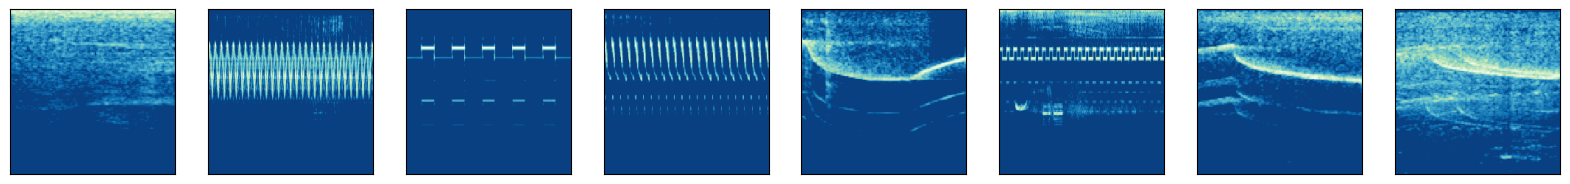

In [31]:
images, labels = load_images_from_path('./Data/spectograms/ambulance', 1)
show_images(images)
    
x += images
y += labels

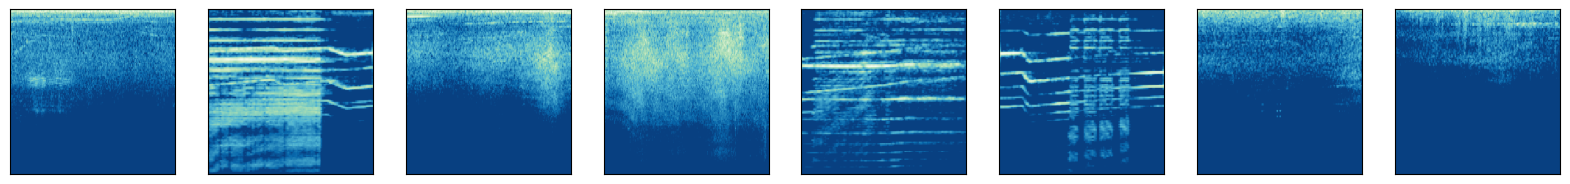

In [32]:
images, labels = load_images_from_path('./Data/spectograms/road', 0)
show_images(images)
    
x += images
y += labels

In [33]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [34]:
print("Shape of x_train_norm:", x_train_norm.shape)
print("Shape of x_test_norm:", x_test_norm.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train_norm: (1283, 224, 224, 3)
Shape of x_test_norm: (551, 224, 224, 3)
Shape of y_train: (1283,)
Shape of y_test: (551,)


In [42]:
### Build and train a CNN


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 32)       

In [43]:
#### train and fit
hist = model.fit(x_train_norm, y_train, validation_data=(x_test_norm, y_test), batch_size=10, epochs=7)


Epoch 1/7
129/129 [==============================] - 39s 301ms/step - loss: 0.4169 - accuracy: 0.8387 - val_loss: 0.2411 - val_accuracy: 0.9093
Epoch 2/7
129/129 [==============================] - 38s 291ms/step - loss: 0.1538 - accuracy: 0.9431 - val_loss: 0.1344 - val_accuracy: 0.9637
Epoch 3/7
129/129 [==============================] - 38s 297ms/step - loss: 0.1179 - accuracy: 0.9634 - val_loss: 0.1878 - val_accuracy: 0.9238
Epoch 4/7
129/129 [==============================] - 37s 288ms/step - loss: 0.1116 - accuracy: 0.9641 - val_loss: 0.5214 - val_accuracy: 0.8675
Epoch 5/7
129/129 [==============================] - 36s 280ms/step - loss: 0.0963 - accuracy: 0.9680 - val_loss: 0.1639 - val_accuracy: 0.9419
Epoch 6/7
129/129 [==============================] - 41s 316ms/step - loss: 0.0595 - accuracy: 0.9829 - val_loss: 0.1149 - val_accuracy: 0.9583
Epoch 7/7
129/129 [==============================] - 37s 284ms/step - loss: 0.0320 - accuracy: 0.9883 - val_loss: 0.1676 - val_accuracy:

[]

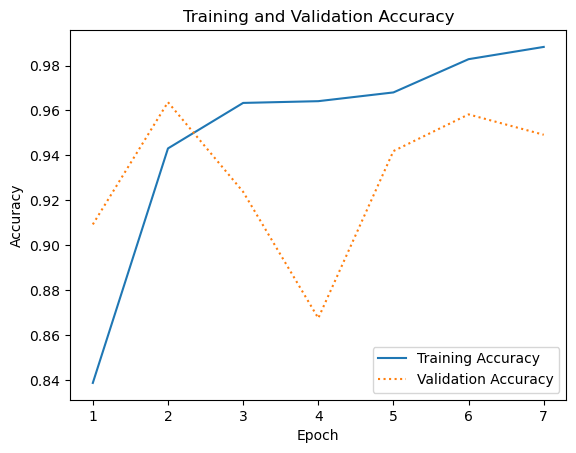

In [44]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [45]:
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


18/18 [==============================] - 4s 220ms/step - loss: 0.1676 - accuracy: 0.9492
Test Loss: 0.1676
Test Accuracy: 0.9492
